<a href="https://colab.research.google.com/github/Khaarl/VIZDOOM-LOC/blob/main/VISDOOMGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# --- Setup ---
!apt-get update -y
!apt-get install -y build-essential cmake git libboost-all-dev libsdl2-dev libjpeg-dev libpng-dev zlib1g-dev libpython3-dev

import os

# Use Mesa for software rendering (CPU-based)
os.environ['LIBGL_ALWAYS_SOFTWARE'] = '1'

# Set XDG_RUNTIME_DIR to avoid other SDL issues
os.environ['XDG_RUNTIME_DIR'] = '/tmp'

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 388 kB in 2s (224 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
R

In [23]:
# --- Install ViZDoom from source (for proper linking) ---
!pip uninstall -y vizdoom
!apt-get install -y libboost-python-dev
!git clone https://github.com/mwydmuch/ViZDoom.git
%cd ViZDoom
!mkdir build && cd build
!cmake .. -DBUILD_PYTHON=ON -DCMAKE_INSTALL_PREFIX=/usr/local
!make -j$(nproc) install
%cd /content
!pip install vizdoom

Found existing installation: vizdoom 1.2.4
Uninstalling vizdoom-1.2.4:
  Successfully uninstalled vizdoom-1.2.4
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-python-dev is already the newest version (1.74.0.3ubuntu7).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
fatal: destination path 'ViZDoom' already exists and is not an empty directory.
/content/ViZDoom
mkdir: cannot create directory ‘build’: File exists
CMake Warning:
  Ignoring extra path from command line:

   ".."


CMake Error: The source directory "/content" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No rule to make target 'install'.  Stop.
/content
  Using cached vizdoom-1.2.4-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (11 kB)
Using cached vizdoom-1.2.4-cp310-cp310-manylinux_2_28_x86_64.whl (28.1 MB)


In [48]:
from google.colab import drive
import imageio
import os
from vizdoom import *
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
from datetime import datetime
import glob
import psutil  # For RAM usage
import gc  # For garbage collection
from collections import Counter
import cv2

# --- Configuration ---
RECORD_LMP = False  # Set to True to record .lmp demo files
RECORD_VIDEO = False  # Set to True to record a video (MP4)
VIDEO_FPS = 30  # Frames per second for video recording
LMP_DIR = "lmp_recordings"  # Directory to save .lmp files
SCENARIO_NAME = "defend_the_center.cfg"  # Default scenario
# --- Google Drive Paths ---
DRIVE_MODEL_DIR = "/content/drive/My Drive/ViZDoomModels"  # Directory in Google Drive to save the model
DRIVE_WAD_DIR = "/content/drive/My Drive/ViZDoomWADs"  # Directory in Google Drive for WAD files
# --- Local Paths ---
LOCAL_WAD_DIR = "/content/ViZDoomWADs"
# --- Frame Stacking ---
STACK_SIZE = 4  # Number of frames to stack

# --- User Input for Recording, Number of Episodes, and FRAME_SKIP ---
record_choice = input("Do you want to record the game? (yes/no): ").lower()
if record_choice == "yes":
    record_lmp_choice = input("Record .lmp demo files? (yes/no): ").lower()
    RECORD_LMP = record_lmp_choice == "yes"
    record_video_choice = input("Record video (MP4)? (yes/no): ").lower()
    RECORD_VIDEO = record_video_choice == "yes"

num_episodes_choice = input("Enter the number of episodes to run: ")
try:
    NUM_EPISODES = int(num_episodes_choice)
except ValueError:
    print("Invalid input. Using default number of episodes (10).")
    NUM_EPISODES = 10

# User input for FRAME_SKIP during training and recording
FRAME_SKIP_TRAINING = int(input("Enter FRAME_SKIP value for training (default 4): ") or "4")
FRAME_SKIP_RECORDING = int(input("Enter FRAME_SKIP value for recording (default 1): ") or "1")
FRAME_SKIP = FRAME_SKIP_TRAINING if not RECORD_VIDEO else FRAME_SKIP_RECORDING

# --- Google Drive Setup ---
drive_mounted = os.path.exists('/content/drive/My Drive')
if not drive_mounted:
    drive.mount('/content/drive')

VIDEO_DIR = "/content/drive/My Drive/ViZDoomRecordings"
VIDEO_FILENAME = "game_recording.mp4"
VIDEO_PATH = os.path.join(VIDEO_DIR, VIDEO_FILENAME)
os.makedirs(VIDEO_DIR, exist_ok=True)
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)
os.makedirs(DRIVE_WAD_DIR, exist_ok=True)  # Create WAD directory on GDrive
os.makedirs(LOCAL_WAD_DIR, exist_ok=True)  # Create WAD directory locally

# --- Ask user for WAD choice ---
print("Choose a WAD file to use:")
print("1. Use current scenario WAD (defend_the_center.cfg with vizdoom assets)")
print("2. Use original Doom WAD from Google Drive (ViZDoomWADs folder with defend_the_center.cfg)")
wad_choice = input("Enter your choice (1 or 2): ")

if wad_choice == "1":
    # Use the default scenario WAD with vizdoom assets
    import vizdoom
    vizdoom_path = os.path.dirname(vizdoom.__file__)
    SCENARIO_PATH = os.path.join(vizdoom_path, "scenarios", SCENARIO_NAME)
    wad_path = None  # No specific WAD, will use the one defined in the CFG

elif wad_choice == "2":
    # Use a WAD from Google Drive (copy to local, then use)
    wad_files = glob.glob(os.path.join(DRIVE_WAD_DIR, "*.wad"))
    if wad_files:
        print("Available WAD files in ViZDoomWADs:")
        for i, file in enumerate(wad_files):
            print(f"{i+1}. {os.path.basename(file)}")
        wad_file_choice = input("Enter the number of the WAD file to use: ")
        try:
            wad_file_choice = int(wad_file_choice)
            if 1 <= wad_file_choice <= len(wad_files):
                wad_path = wad_files[wad_file_choice - 1]
                local_wad_path = os.path.join(LOCAL_WAD_DIR, os.path.basename(wad_path))
                # Copy the WAD file from Google Drive to the local directory
                if not os.path.exists(local_wad_path):
                    print(f"Copying {os.path.basename(wad_path)} from Google Drive to local...")
                    import shutil
                    shutil.copy(wad_path, local_wad_path)
                    print("Copy complete.")
                else:
                    print(f"{os.path.basename(wad_path)} already exists locally. Using local copy.")
                wad_path = local_wad_path

                # Update scenario to defend_the_center.cfg (should be compatible)
                SCENARIO_NAME = "defend_the_center.cfg"
                import vizdoom
                vizdoom_path = os.path.dirname(vizdoom.__file__)
                SCENARIO_PATH = os.path.join(vizdoom_path, "scenarios", SCENARIO_NAME)

            else:
                raise ValueError("Invalid WAD file choice.")
        except ValueError:
            print("Invalid input. Using default scenario.")
            wad_path = None  # Default back to scenario WAD
    else:
        print("No WAD files found in ViZDoomWADs. Using default scenario.")
        wad_path = None  # Default back to scenario WAD
else:
    print("Invalid choice. Using default scenario.")
    wad_path = None  # Default back to scenario WAD

# --- DQN ---
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self.get_conv_output(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_conv_output(self, shape):
        o = self.conv1(torch.zeros(1, *shape))
        o = self.conv2(o)
        o = self.conv3(o)
        return int(np.prod(o.size()))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, state_shape, num_actions, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay, memory_capacity, batch_size):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_shape, num_actions).to(self.device)
        self.target_net = DQN(state_shape, num_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                q_values = self.policy_net(state)
                return q_values.argmax(dim=1).item()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = tuple(zip(*transitions))

        state_batch = torch.tensor(np.array(batch[0]), dtype=torch.float32, device=self.device)
        action_batch = torch.tensor(batch[1], dtype=torch.long, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(batch[2], dtype=torch.float32, device=self.device).unsqueeze(1)
        next_state_batch = torch.tensor(np.array(batch[3]), dtype=torch.float32, device=self.device)
        done_batch = torch.tensor(batch[4], dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values = self.policy_net(state_batch).gather(1, action_batch)

        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
            expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

        loss = nn.MSELoss()(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# --- User Input for Training Parameters ---
print("Enter training parameters (press Enter to use default values):")

MODEL_SAVE_FREQ = int(input(f"  Model Save Frequency (episodes between saves, default: {10}): ") or "10")
BATCH_SIZE = int(input(f"  Batch Size (default: {64}): ") or "64")
MEMORY_CAPACITY = int(input(f"  Memory Capacity (default: {10000}): ") or "10000")
LEARNING_RATE = float(input(f"  Learning Rate (default: {0.0001}): ") or "0.0001")

# --- Training Parameters ---
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.995
# NUM_EPISODES is set via user input earlier
# FRAME_SKIP values are set via user input earlier

# --- ViZDoom Setup ---
game = DoomGame()
game.load_config(SCENARIO_PATH)
if wad_path:
    game.set_doom_game_path(wad_path)  # Set path to the Doom WAD
game.set_window_visible(False)
game.set_screen_format(ScreenFormat.RGB24)
game.set_screen_resolution(ScreenResolution.RES_320X240)

if RECORD_LMP:
    game.set_mode(Mode.PLAYER)
    os.makedirs(LMP_DIR, exist_ok=True)

game.init()
num_actions = game.get_available_buttons_size()

# --- One-hot encoding for actions ---
actions = np.identity(num_actions, dtype=int).tolist()


# --- Get initial state shape ---
screen_height, screen_width = game.get_screen_height(), game.get_screen_width()
channels = game.get_screen_channels()
# state_shape = (channels, screen_height, screen_width) # Update state_shape
state_shape = (STACK_SIZE * channels, 84, 84) # Update state_shape for stacked frames

# --- Scan for existing models ---
model_files = glob.glob(os.path.join(DRIVE_MODEL_DIR, "*.pth"))

if model_files:
    print("Available models:")
    for i, file in enumerate(model_files):
        print(f"{i+1}. {os.path.basename(file)}")
    print(f"{len(model_files)+1}. Create new model")

    choice = input("Enter your choice: ")
    try:
        choice = int(choice)
        if choice in range(1, len(model_files) + 2):
          if choice <= len(model_files):
            # Load existing model
            model_path = model_files[choice - 1]
            agent = DQNAgent(state_shape, num_actions, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, MEMORY_CAPACITY, BATCH_SIZE)
            agent.policy_net.load_state_dict(torch.load(model_path, weights_only=True))  # Load with weights_only=True
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
            print(f"Model loaded from {model_path}")
          else:
            # --- Create Agent ---
            agent = DQNAgent(state_shape, num_actions, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, MEMORY_CAPACITY, BATCH_SIZE)
            print("Creating new model...")
        else:
            print("Invalid choice. Creating new model...")
            # --- Create Agent ---
            agent = DQNAgent(state_shape, num_actions, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, MEMORY_CAPACITY, BATCH_SIZE)
    except ValueError:
        print("Invalid input. Creating new model...")
        # --- Create Agent ---
        agent = DQNAgent(state_shape, num_actions, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, MEMORY_CAPACITY, BATCH_SIZE)
else:
    print("No existing models found. Creating new model...")
    # --- Create Agent ---
    agent = DQNAgent(state_shape, num_actions, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, MEMORY_CAPACITY, BATCH_SIZE)

# --- Video Writer ---
if RECORD_VIDEO:
    writer = imageio.get_writer(VIDEO_PATH, fps=VIDEO_FPS)

# --- Tracking Variables ---
episode_rewards = []  # List to store rewards per episode
episode_lengths = []  # List to store the number of steps per episode
episode_damage_taken = [] # List to store damage taken per episode
episode_damage_inflicted = [] # List to store damage inflicted per episode
episode_survival_times = [] # List to store survival time per episode
inference_times = [] # List to store inference times
training_start_time = time.time()

# --- Frame Stacking ---
def preprocess_frame(frame):
    # Convert to grayscale (if necessary) and normalize
    if len(frame.shape) == 3 and frame.shape[0] == 3:
        frame = np.mean(frame, axis=0)
    frame = frame.astype(np.float32) / 255.0
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    # Transpose to (channels, height, width)
    # Assuming frame is originally in (height, width, channels) format
    if len(frame.shape) == 3:  # Color image
        frame = frame.transpose(2, 0, 1)
    else:  # Grayscale, add a channel dimension
        frame = np.expand_dims(frame, axis=0)
    return frame

def create_stacked_state(state_buffer):
    processed_frames = [preprocess_frame(f) for f in state_buffer]
    # Ensure all frames are not None and have the same shape
    if any(f is None for f in processed_frames) or not all(f.shape == processed_frames[0].shape for f in processed_frames):
        print("Error: Inconsistent or None frames in processed_frames")
        return None

    stacked_state = np.concatenate(processed_frames, axis=0)
    return stacked_state

# --- Training Loop ---
TICRATE = 35 # Internal ticrate of ViZDoom (for syncing with video FPS, if needed)

for episode in range(NUM_EPISODES):
    if RECORD_LMP:
        lmp_file_path = os.path.join(LMP_DIR, f"episode_{episode + 1}.lmp")
        game.new_episode(lmp_file_path)
    else:
        game.new_episode()

    # --- Print available game variables and their indices ---
    if episode == 0:  # Print only once at the beginning
        print("Available Game Variables:")
        for i, var in enumerate(game.get_available_game_variables()):
            print(f"  Index {i}: {var}")

    # --- Initialize state with frame stacking ---
    game_state = game.get_state()
    state_buffer = [game_state.screen_buffer] * STACK_SIZE  # Initialize buffer
    state = create_stacked_state(state_buffer)
    if state is None:
        print(f"Skipping episode {episode + 1} due to state initialization error.")
        continue

    total_reward = 0
    step_count = 0
    episode_start_time = time.time()
    damage_taken = 0
    damage_inflicted = 0
    action_counts = Counter()

    while not game.is_episode_finished():
        # --- Measure inference time ---
        inference_start_time = time.time()
        action_index = agent.select_action(state)
        inference_end_time = time.time()
        inference_times.append(inference_end_time - inference_start_time)

        action = actions[action_index]
        action_counts[action_index] += 1

        # Make the action with the appropriate FRAME_SKIP value
        reward = game.make_action(action, FRAME_SKIP)
        done = game.is_episode_finished()

        # --- Get game variables and update state buffer ---
        if not done:
            game_state = game.get_state()
            next_frame = game_state.screen_buffer
            state_buffer.pop(0)  # Remove oldest frame
            state_buffer.append(next_frame)  # Add new frame
            next_state = create_stacked_state(state_buffer)  # Create stacked state
            if next_state is None:
                print(f"Error: next_state is None in episode {episode + 1} at step {step_count + 1}.")
                break

            # Update with CORRECT indices from the printed output
            damage_taken += game_state.game_variables[0]  # Replace 0 with the correct index
            damage_inflicted += game_state.game_variables[1]  # Replace 1 with the correct index
        else:
            next_state = np.zeros(state_shape)

        agent.memory.push(state, action_index, reward, next_state, done)
        agent.learn()

        state = next_state
        total_reward += reward
        step_count += 1

        # Changed Recording code here
        if RECORD_VIDEO and not done:
          most_recent_frame = state_buffer[-1]
          writer.append_data(most_recent_frame)

        if done:
            break

    episode_survival_time = time.time() - episode_start_time
    episode_survival_times.append(episode_survival_time)
    episode_rewards.append(total_reward)
    episode_lengths.append(step_count)
    episode_damage_taken.append(damage_taken)
    episode_damage_inflicted.append(damage_inflicted)
    agent.update_epsilon()
    if episode % MODEL_SAVE_FREQ == 0:
      # --- Save the trained model ---
      model_filename = f"{dt_string}_dqn_model_episode_{episode + 1}.pth"
      model_path = os.path.join(DRIVE_MODEL_DIR, model_filename)
      torch.save(agent.policy_net.state_dict(), model_path)
    if episode % 10 == 0:
        agent.update_target_network()

    # --- Calculate action diversity ---
    total_actions = sum(action_counts.values())
    action_diversity = sum(count / total_actions for count in action_counts.values()) / num_actions

    # --- Get memory usage ---
    process = psutil.Process(os.getpid())
    ram_usage = process.memory_info().rss / 1024**2  # in MB
    if torch.cuda.is_available():
        gpu_memory_usage = torch.cuda.max_memory_allocated() / 1024**2 # in MB
    else:
      gpu_memory_usage = 0

    # --- Logging ---
    avg_reward = np.mean(episode_rewards[-100:])
    avg_survival_time = np.mean(episode_survival_times[-100:])
    avg_inference_time = np.mean(inference_times[-100:])
    print(f"Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Steps: {step_count}, Epsilon: {agent.epsilon:.3f}, Avg Reward (last 100): {avg_reward:.2f}, Survival Time: {episode_survival_time:.2f}s, Avg Survival Time (last 100): {avg_survival_time:.2f}s, Damage Taken: {damage_taken}, Damage Inflicted: {damage_inflicted}, Avg Inference Time: {avg_inference_time:.4f}s, RAM Usage: {ram_usage:.2f}MB, GPU Mem Usage: {gpu_memory_usage:.2f}MB, Action Diversity: {action_diversity:.2f}")

    # --- Clear memory ---
    del action_counts
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Get current date and time for file name prefix ---
now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M")  # Format: YYYYMMDDHHMM

# --- Save metrics to CSV ---
training_end_time = time.time()
metrics_df = pd.DataFrame({
    'episode': range(1, NUM_EPISODES + 1),
    'reward': episode_rewards,
    'steps': episode_lengths,
    'epsilon': [EPSILON_START * (EPSILON_DECAY ** i) for i in range(NUM_EPISODES)],
    'training_time': training_end_time - training_start_time,
    'survival_time': episode_survival_times,
    'damage_taken': episode_damage_taken,
    'damage_inflicted': episode_damage_inflicted,
    'ram_usage': ram_usage,
    'gpu_memory_usage': gpu_memory_usage,
    'action_diversity': action_diversity,
    'model_save_freq': MODEL_SAVE_FREQ,
    'batch_size': BATCH_SIZE,
    'memory_capacity': MEMORY_CAPACITY,
    'learning_rate': LEARNING_RATE
})

metrics_filename = f"{dt_string}_training_metrics.csv"
metrics_path = os.path.join(DRIVE_MODEL_DIR, metrics_filename)
metrics_df.to_csv(metrics_path, index=False)

# Close the writer
if RECORD_VIDEO:
    writer.close()

game.close()
print("Done!")

Do you want to record the game? (yes/no): no
Enter the number of episodes to run: 20
Enter FRAME_SKIP value for training (default 4): 4
Enter FRAME_SKIP value for recording (default 1): 
Choose a WAD file to use:
1. Use current scenario WAD (defend_the_center.cfg with vizdoom assets)
2. Use original Doom WAD from Google Drive (ViZDoomWADs folder with defend_the_center.cfg)
Enter your choice (1 or 2): 1
Enter training parameters (press Enter to use default values):
  Model Save Frequency (episodes between saves, default: 10): 19
  Batch Size (default: 64): 128
  Memory Capacity (default: 10000): 
  Learning Rate (default: 0.0001): 
Available models:
1. 202501022031_dqn_model_episode_1.pth
2. 202501022046_dqn_model_episode_1.pth
3. 202501022050_dqn_model_episode_1.pth
4. 202501022058_dqn_model_episode_1.pth
5. 202501022102_dqn_model_episode_1.pth
6. 202501022102_dqn_model_episode_11.pth
7. 202501022107_dqn_model_episode_1.pth
8. 202501022107_dqn_model_episode_11.pth
9. 202501022113_dqn_m

Processing: /content/drive/My Drive/ViZDoomModels/202501022031_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022046_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022050_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022058_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022102_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022107_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022113_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022133_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022134_training_metrics.csv
Processing: /content/drive/My Drive/ViZDoomModels/202501022153_training_metrics.csv


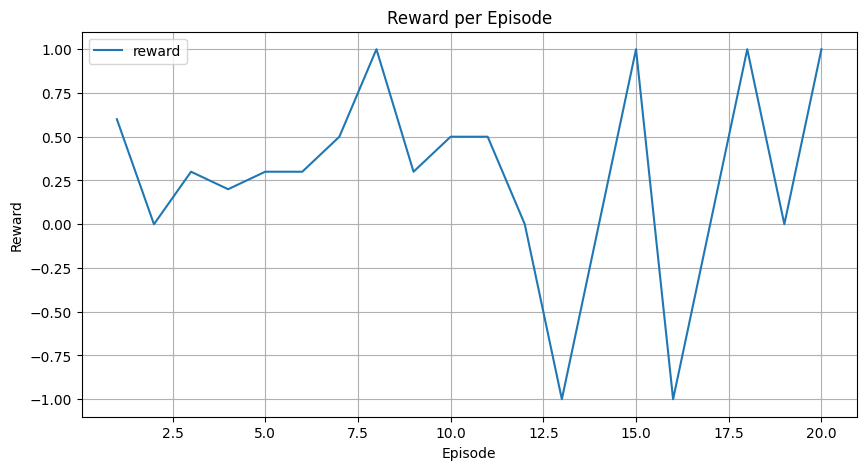

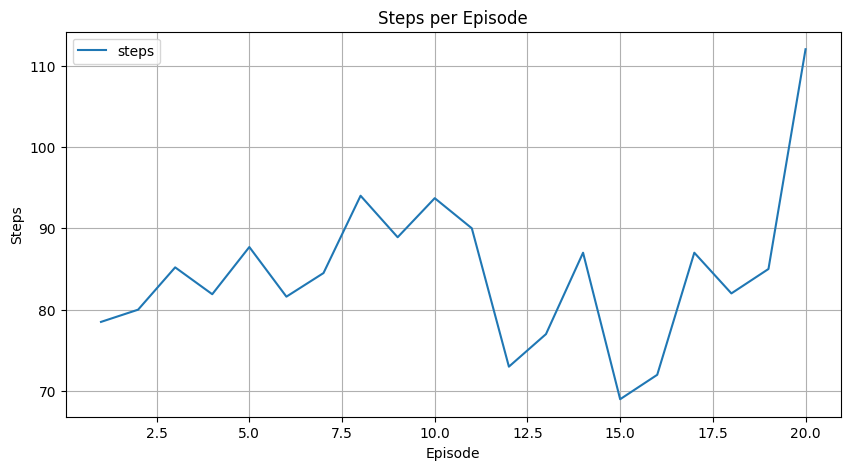

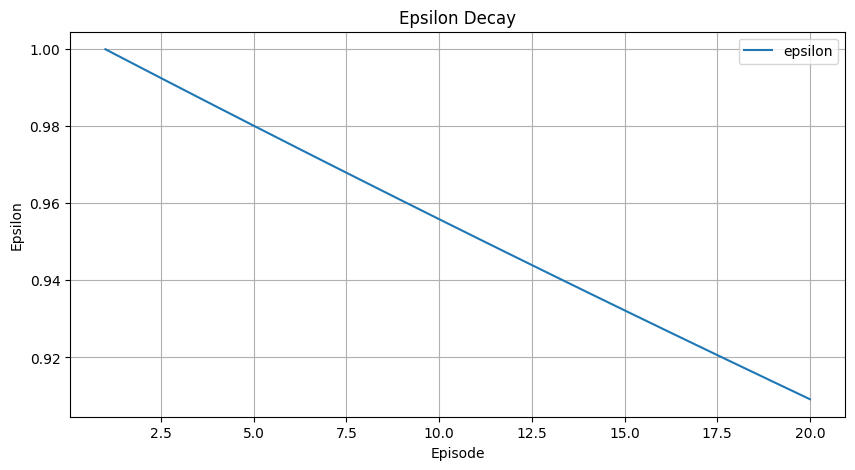

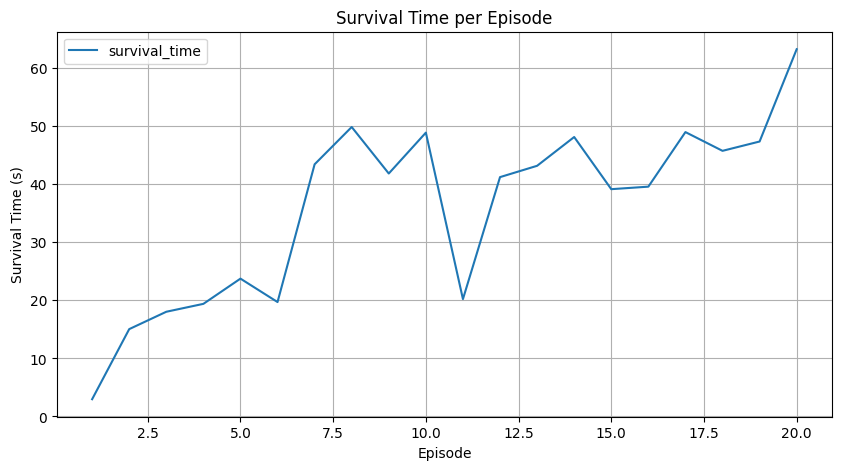

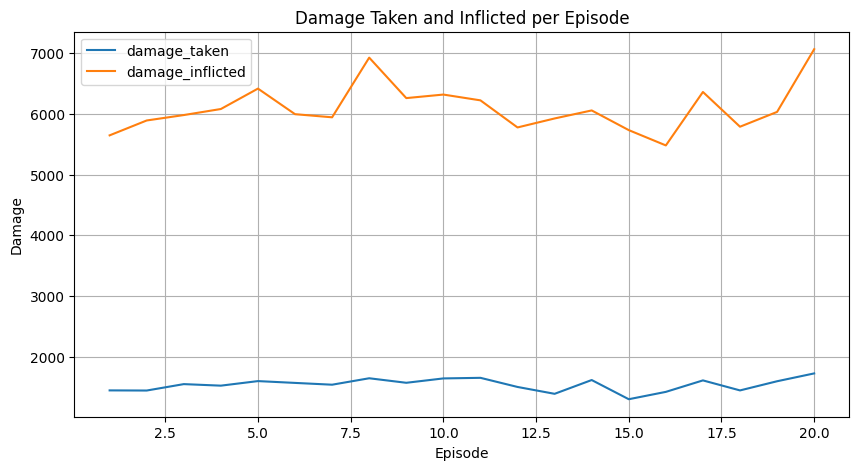

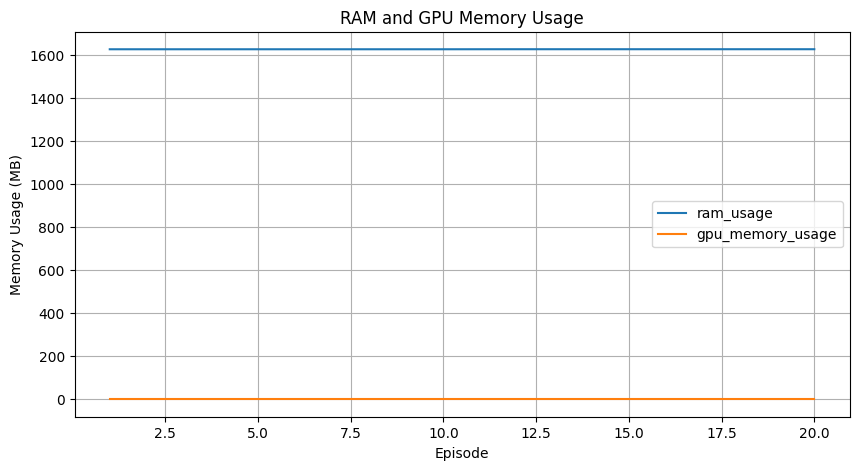

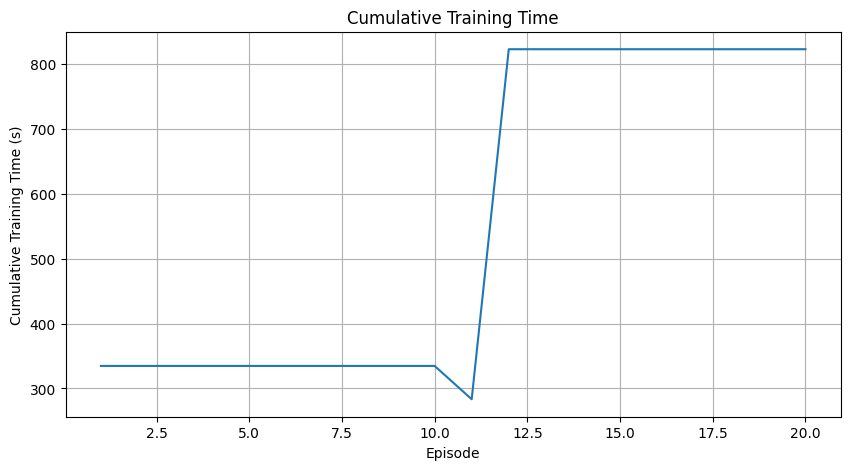

In [49]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# --- Google Drive Paths (Same as in your main code) ---
DRIVE_MODEL_DIR = "/content/drive/My Drive/ViZDoomModels"

# --- Mount Google Drive ---
drive_mounted = os.path.exists('/content/drive/My Drive')
if not drive_mounted:
    drive.mount('/content/drive')

# --- Function to Plot Metrics ---
def plot_metrics(df, metrics_to_plot, ylabel, title, save_as=None):
    plt.figure(figsize=(10, 5))

    # Plot each metric with a label for the legend
    for metric in metrics_to_plot:
        plt.plot(df['episode'], df[metric], label=metric)

    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()  # Show the legend to identify each metric
    plt.grid(True)

    if save_as:
        plt.savefig(save_as)

    plt.show()

# --- Search for metrics files ---
metrics_files = glob.glob(os.path.join(DRIVE_MODEL_DIR, "*training_metrics.csv"))

if not metrics_files:
    print("No training metrics files found in the specified directory.")
else:
    all_dfs = []  # List to store DataFrames from each CSV

    for metrics_file in metrics_files:
        print(f"Processing: {metrics_file}")
        df = pd.read_csv(metrics_file)
        all_dfs.append(df)

    # --- Concatenate all DataFrames into a single DataFrame ---
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # --- Aggregate data if needed ---
    # Calculate the mean of each metric for each episode across all files
    combined_df = combined_df.groupby('episode').mean().reset_index()

    # --- Create plots using the combined DataFrame ---
    # 1. Reward per Episode
    plot_metrics(combined_df, ['reward'], 'Reward', 'Reward per Episode', os.path.join(DRIVE_MODEL_DIR, 'combined_reward_plot.png'))

    # 2. Steps per Episode
    plot_metrics(combined_df, ['steps'], 'Steps', 'Steps per Episode', os.path.join(DRIVE_MODEL_DIR, 'combined_steps_plot.png'))

    # 3. Epsilon Decay
    plot_metrics(combined_df, ['epsilon'], 'Epsilon', 'Epsilon Decay', os.path.join(DRIVE_MODEL_DIR, 'combined_epsilon_plot.png'))

    # 4. Survival Time per Episode
    plot_metrics(combined_df, ['survival_time'], 'Survival Time (s)', 'Survival Time per Episode', os.path.join(DRIVE_MODEL_DIR, 'combined_survival_time_plot.png'))

    # 5. Damage Taken and Inflicted per Episode
    plot_metrics(combined_df, ['damage_taken', 'damage_inflicted'], 'Damage', 'Damage Taken and Inflicted per Episode', os.path.join(DRIVE_MODEL_DIR, 'combined_damage_plot.png'))

    # 6. RAM and GPU Memory Usage
    plot_metrics(combined_df, ['ram_usage', 'gpu_memory_usage'], 'Memory Usage (MB)', 'RAM and GPU Memory Usage', os.path.join(DRIVE_MODEL_DIR, 'combined_memory_usage_plot.png'))

    # 7. Training Time
    plt.figure(figsize=(10, 5))
    plt.plot(combined_df['episode'], combined_df['training_time'], label='Training Time')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Training Time (s)')
    plt.title('Cumulative Training Time')
    plt.grid(True)
    plt.savefig(os.path.join(DRIVE_MODEL_DIR, 'combined_training_time_plot.png'))
    plt.show()